# RNN을 이용한 SNS Spam 분류
- 데이터 다운로드 캐글 : [SMS Spam Collection Dataset](https://www.kaggle.com/uciml/sms-spam-collection-dataset)

### 한글폰트 사용

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

seed = 2021
np.random.seed(seed)
tf.random.set_seed(seed)

In [5]:
# 실행 후 런타임 다시 시작
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 10 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('font', family='NanumBarunGothic') 

In [8]:
from google.colab import files

uploaded = files.upload()
filename = list(uploaded.keys())[0]

Saving spam.csv to spam.csv


In [9]:
import pandas as pd

df = pd.read_csv(filename, encoding='latin1')
df.head(3)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN


In [10]:
del df['Unnamed: 2']
del df['Unnamed: 3']
del df['Unnamed: 4']
df['v1'] = df['v1'].replace(['ham', 'spam'], [0, 1])
df.head()

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   int64 
 1   v2      5572 non-null   object
dtypes: int64(1), object(1)
memory usage: 87.2+ KB


In [13]:
df.isnull().sum()

v1    0
v2    0
dtype: int64

In [17]:
df['v2'].nunique()

5169

In [18]:
# 중복데이터 제거
df = df.drop_duplicates('v2', keep='first')

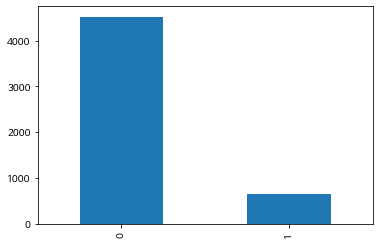

In [20]:
df['v1'].value_counts().plot(kind='bar');

In [22]:
df['v1'].value_counts()

0    4516
1     653
Name: v1, dtype: int64

In [23]:
X_data = df['v2'].values
y_data = df['v1'].values
print('SMS 본문의 개수:', len(X_data))
print('레이블의 개수:', len(y_data))

SMS 본문의 개수: 5169
레이블의 개수: 5169


In [24]:
 X_data[2]

"Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"

In [25]:
from string import punctuation
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [55]:
# 구두점 제거와 소문자화를 위한 함수
def preprocessing(s):
  s=s.encode("utf8").decode("ascii", "ignore")
  return ''.join(c for c in s if c not in punctuation).lower()

In [56]:
X_punct= [preprocessing(x) for x in X_data]
X_punct[2]

'free entry in 2 a wkly comp to win fa cup final tkts 21st may 2005 text fa to 87121 to receive entry questionstd txt ratetcs apply 08452810075over18s'

In [57]:
# 단어 집합(vocabulary)을 만들고 크기를 확인
t = Tokenizer()
t.fit_on_texts(X_data)
sequences = t.texts_to_sequences(X_data)
vocab_size = len(t.word_index)+1
word_to_index = t.word_index
print('단어 집합의 크기 : %d' % vocab_size)

단어 집합의 크기 : 8921


In [58]:
t2 = Tokenizer()
t2.fit_on_texts(X_punct)
sequences2 = t2.texts_to_sequences(X_punct)
vocab_size2 = len(t2.word_index)+1
word_to_index2 = t.word_index
print('단어 집합의 크기 : %d' % vocab_size2)

단어 집합의 크기 : 9480


#### 구둣점 제거한 것이 오히려 단어가 많아짐

In [61]:
threshold = 2
total_cnt = len(word_to_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in t.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print(f'등장 빈도가 {threshold - 1}번 이하인 희귀 단어의 수:  {rare_cnt}')
print("단어 집합(vocabulary)에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

등장 빈도가 1번 이하인 희귀 단어의 수:  4908
단어 집합(vocabulary)에서 희귀 단어의 비율: 55.02242152466368
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.082538108811501


메일의 최대 길이 : 189
메일의 평균 길이 : 15.6104


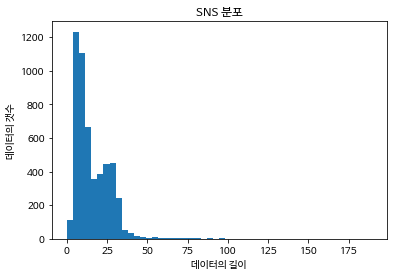

In [64]:
X_data = sequences
max_len = max(len(l) for l in X_data)
print(f'메일의 최대 길이 : {max_len}')
print(f'메일의 평균 길이 : {(sum(map(len, X_data))/len(X_data)):.4f}')

plt.hist([len(s) for s in X_data], bins=50)
plt.xlabel('데이터의 길이')
plt.ylabel('데이터의 갯수')
plt.title('SNS 분포')
plt.show()

In [65]:
# 전체 데이터셋의 길이를 max_len(189)에 맞춤
data = pad_sequences(X_data, maxlen=max_len)
data.shape

(5169, 189)

In [69]:
# 테스트용 데이터 20% 분리
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(data, y_data, stratify=y_data, test_size=0.2, random_state=seed)

In [70]:
X_train.shape, X_test.shape

((4135, 189), (1034, 189))

### 모델 정의 / 설정 / 학습

In [75]:
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense
from tensorflow.keras.models import Sequential

In [76]:
model = Sequential()
model.add(Embedding(vocab_size, 32)) # 임베딩 벡터의 차원은 32
model.add(SimpleRNN(32))             # RNN 셀의 hidden_size는 32
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          285472    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 287,585
Trainable params: 287,585
Non-trainable params: 0
_________________________________________________________________


In [77]:
model.compile(optimizer='rmsprop', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [78]:
# 훈련용 데이터 중에서 20%는 검증 데이터로 사용
history = model.fit(X_train, y_train, epochs=10, 
                    batch_size=60, validation_split=0.2)

Epoch 1/10
56/56 [==============================] - 4s 49ms/step - loss: 0.3747 - accuracy: 0.8758 - val_loss: 0.1519 - val_accuracy: 0.9480
Epoch 2/10
56/56 [==============================] - 2s 41ms/step - loss: 0.1008 - accuracy: 0.9742 - val_loss: 0.0616 - val_accuracy: 0.9843
Epoch 3/10
56/56 [==============================] - 2s 41ms/step - loss: 0.0537 - accuracy: 0.9858 - val_loss: 0.0557 - val_accuracy: 0.9855
Epoch 4/10
56/56 [==============================] - 2s 41ms/step - loss: 0.0380 - accuracy: 0.9871 - val_loss: 0.0549 - val_accuracy: 0.9831
Epoch 5/10
56/56 [==============================] - 2s 42ms/step - loss: 0.0163 - accuracy: 0.9968 - val_loss: 0.0675 - val_accuracy: 0.9782
Epoch 6/10
56/56 [==============================] - 2s 42ms/step - loss: 0.0135 - accuracy: 0.9959 - val_loss: 0.0566 - val_accuracy: 0.9843
Epoch 7/10
56/56 [==============================] - 2s 43ms/step - loss: 0.0079 - accuracy: 0.9988 - val_loss: 0.0732 - val_accuracy: 0.9758
Epoch 8/10
56

In [87]:
# 테스트 정확도
print(f"\n 테스트 정확도: {model.evaluate(X_test, y_test, verbose=2)[1]}")

33/33 - 0s - loss: 0.0598 - accuracy: 0.9836

 테스트 정확도: 0.9835590124130249


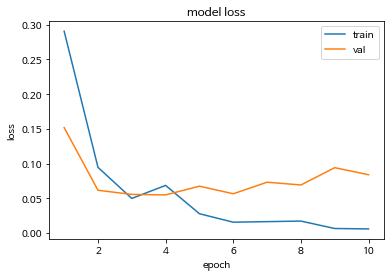

In [88]:
epochs = range(1, len(history.history['accuracy']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()